# WH all hadronic analysis

Basic implementation of an all-hadronic WH search in the top-W scattering framework:
- Loose Lepton veto
- at least 2 jets
- at least one b-tagged jets
- high MET
- veto QCD



In [61]:
%load_ext autoreload
%autoreload 2

import os
import time
import glob
import re
import pandas as pd
from functools import reduce
from klepto.archives import dir_archive

import numpy as np
from tqdm.auto import tqdm
import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
from coffea.analysis_objects import JaggedCandidateArray
from coffea.btag_tools import BTagScaleFactor
from coffea import hist
import pandas as pd
import uproot_methods
import uproot
import awkward
import copy

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from Tools.config_helpers import *
from Tools.helpers import mergeArray, mt, get_scheduler_address

from Tools.objects import Collections
from Tools.cutflow import Cutflow

# This just tells matplotlib not to open any
# interactive windows.
matplotlib.use('Agg')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
def pad_and_flatten(val): 
    try:
        return val.pad(1, clip=True).fillna(0.).flatten()#.reshape(-1, 1)
    except AttributeError:
        return val.flatten()

#os.environ['KERAS_BACKEND'] = 'theano'
#from keras.models import load_model


In [63]:
import sys
sys.setrecursionlimit(10000)
print(sys.getrecursionlimit())

10000


In [64]:
from Tools.WH_objects import *
from Tools.WH_scalefactors import LeptonSF
from Tools.WH_deepAK8 import getWTagSF

In [91]:
year = 2018
class analysisProcessor(processor.ProcessorABC):
    """Processor used for running the analysis"""
    def __init__(self):
        
        ## load b-tag SFs
        #self.btag_sf = BTagScaleFactor(os.path.expandvars("$TWHOME/data/DeepCSV_102XSF_V1.btag.csv.gz", "reshape")

        ## load the NN
        #self.model = load_model('../ML/data/training.h5')
        #self.stds  = pd.read_json('../ML/data/stds.json').squeeze()
        #self.means = pd.read_json('../ML/data/means.json').squeeze()
        
        # we can use a large number of bins and rebin later
        dataset_axis        = hist.Cat("dataset",   "Primary dataset")
        pt_axis             = hist.Bin("pt",        r"$p_{T}$ (GeV)", 1000, 0, 1000)
        p_axis              = hist.Bin("p",         r"$p$ (GeV)", 1000, 0, 2500)
        ht_axis             = hist.Bin("ht",        r"$H_{T}$ (GeV)", 500, 0, 5000)
        mass_axis           = hist.Bin("mass",      r"M (GeV)", 1000, 0, 2000)
        eta_axis            = hist.Bin("eta",       r"$\eta$", 60, -5.5, 5.5)
        delta_axis          = hist.Bin("delta",     r"$\delta$", 100,0,10 )
        multiplicity_axis   = hist.Bin("multiplicity",         r"N", 20, -0.5, 19.5)
        norm_axis           = hist.Bin("norm",         r"N", 25, 0, 1)

        self._accumulator = processor.dict_accumulator({
            "MET_pt_baseline" :          hist.Hist("Counts", dataset_axis, pt_axis),
            "HT_baseline" :              hist.Hist("Counts", dataset_axis, ht_axis),
            "mtb_min_baseline" :         hist.Hist("Counts", dataset_axis, mass_axis),
            "MET_pt" :          hist.Hist("Counts", dataset_axis, pt_axis),
            "HT" :              hist.Hist("Counts", dataset_axis, ht_axis),
            "mtb_min" :         hist.Hist("Counts", dataset_axis, mass_axis),
            "MET_pt_SR" :       hist.Hist("Counts", dataset_axis, pt_axis),
            "MET_pt_CR" :       hist.Hist("Counts", dataset_axis, pt_axis),
            "MET_pt_TT" :       hist.Hist("Counts", dataset_axis, pt_axis),
            "HT_SR" :           hist.Hist("Counts", dataset_axis, ht_axis),
            "mtb_min_SR" :      hist.Hist("Counts", dataset_axis, mass_axis),
            "mth_min_SR" :      hist.Hist("Counts", dataset_axis, mass_axis),
            "mth_min" :         hist.Hist("Counts", dataset_axis, mass_axis),
            "mtw_min_SR" :      hist.Hist("Counts", dataset_axis, mass_axis),
            "lead_AK8_pt" :     hist.Hist("Counts", dataset_axis, pt_axis),
            "W_pt" :            hist.Hist("Counts", dataset_axis, pt_axis),
            "H_pt" :            hist.Hist("Counts", dataset_axis, pt_axis),
            "W_msoftdrop":      hist.Hist("Counts", dataset_axis, mass_axis),
            "H_msoftdrop":      hist.Hist("Counts", dataset_axis, mass_axis),
            "W_mass":           hist.Hist("Counts", dataset_axis, mass_axis),
            "H_mass":           hist.Hist("Counts", dataset_axis, mass_axis),
            "W_eta" :           hist.Hist("Counts", dataset_axis, eta_axis),
            "H_eta" :           hist.Hist("Counts", dataset_axis, eta_axis),
            
            "N_b" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_AK4" :           hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_AK4_SR" :        hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_AK8" :           hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_H" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_W" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            
            "WH_deltaPhi":      hist.Hist("Counts", dataset_axis, delta_axis),
            "WH_deltaR":        hist.Hist("Counts", dataset_axis, delta_axis),
            "bb_deltaPhi":      hist.Hist("Counts", dataset_axis, delta_axis),
            "bb_deltaR":        hist.Hist("Counts", dataset_axis, delta_axis),
            "min_dphiJetMet4":  hist.Hist("Counts", dataset_axis, delta_axis),
            "min_dphiFatJetMet4":  hist.Hist("Counts", dataset_axis, delta_axis),
            "min_deltaRAK4AK8": hist.Hist("Counts", dataset_axis, delta_axis),
            "min_deltaRAK4AK8_SR": hist.Hist("Counts", dataset_axis, delta_axis),
            "dphiDiJet":        hist.Hist("Counts", dataset_axis, delta_axis),
            "dphiDiFatJet":     hist.Hist("Counts", dataset_axis, delta_axis),
            
            'mC750_l1':         processor.defaultdict_accumulator(int),
            '750_1_scan':       processor.defaultdict_accumulator(int),
            '1000_1_scan':      processor.defaultdict_accumulator(int),
            'WJets':            processor.defaultdict_accumulator(int),
            'QCD':              processor.defaultdict_accumulator(int),
            'TTJets':           processor.defaultdict_accumulator(int),
            'ZNuNu':            processor.defaultdict_accumulator(int),
            'ST':               processor.defaultdict_accumulator(int),
            'ttW/ttZ':          processor.defaultdict_accumulator(int),
            'WW/WZ/ZZ':         processor.defaultdict_accumulator(int),
            'LL':               processor.defaultdict_accumulator(int),
            'Data':             processor.defaultdict_accumulator(int),
            'totalEvents':      processor.defaultdict_accumulator(int),
            'test1':            processor.defaultdict_accumulator(float),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        """
        Processing function. This is where the actual analysis happens.
        """
        output = self.accumulator.identity()
        dataset = df["dataset"]
        cfg = loadConfig()
        
        ## This is hacked in and should go somewhere else
        signal_xsec = {'750_1_scan': {'xsec': 6.69356, 'sumweight': 68870.0},
                      '1000_1_scan': {'xsec': 1.34352, 'sumweight': 77478.0}}
        
        ## correct x-sec
        if dataset.count('scan'):
            df['weight'] = df['weight'] * signal_xsec[dataset]['xsec'] / signal_xsec[dataset]['sumweight']
        
        ## MET -> can switch to puppi MET
        met_pt  = df["MET_pt"]
        met_phi = df["MET_phi"]
        
        muon          = getMuons(df, WP='veto')
        electron      = getElectrons(df, WP='veto')
        tau           = getTaus(df)
        isotrack      = getIsoTracks(df)
        fatjet        = getFatJets(df)
        jet           = getJets(df)
        
        filters  = getFilters(df, year=year, dataset=dataset)
        triggers = getTriggers(df, year=year, dataset=dataset)
        blind_protection = True if dataset.lower().count('data')==0 else (electron.counts+muon.counts)>0
        
        sf = LeptonSF(year=year)
        leptonSF = sf.get(electron, muon)
        
        leadingFatJets = fatjet[:,:2]
        difatjet = leadingFatJets.choose(2)
        dphiDiFatJet = np.arccos(np.cos(difatjet.i0.phi-difatjet.i1.phi))
        
        min_dphiFatJetMet4 = np.arccos(np.cos(fatjet[:,:4].phi-met_phi)).min()
        
        htag = fatjet[((fatjet.pt > 200) & (fatjet.deepTagMD_HbbvsQCD > 0.8365))]
        htag_hard = fatjet[((fatjet.pt > 300) & (fatjet.deepTagMD_HbbvsQCD > 0.8365))]
        
        lead_htag = htag[htag.pt.argmax()]
        
        # deepAK8 working points: https://twiki.cern.ch/twiki/bin/viewauth/CMS/DeepAK8Tagging2018WPsSFs
        wtag = fatjet[((fatjet.pt > 200) & (fatjet.deepTagMD_HbbvsQCD < 0.8365) & (fatjet.deepTag_WvsQCD > 0.918))]
        wtag_vloose = fatjet[((fatjet.pt > 200) & (fatjet.deepTagMD_HbbvsQCD < 0.8365) & (fatjet.deepTag_WvsQCD > 0.458))]
        wtag_loose = fatjet[((fatjet.pt > 200) & (fatjet.deepTagMD_HbbvsQCD < 0.8365) & (fatjet.deepTag_WvsQCD > 0.762))]
        wtag_hard = fatjet[((fatjet.pt > 300) & (fatjet.deepTagMD_HbbvsQCD < 0.8365) & (fatjet.deepTag_WvsQCD > 0.918))]
        
        if dataset.lower().count('data')==0:
            GenW = getGenW(df)
            wtag_SF = getWTagSF(wtag, GenW, year=year)
        
        lead_wtag = wtag[wtag.pt.argmax()]
        
        wh = lead_htag.cross(lead_wtag)
        wh_deltaPhi = np.arccos(wh.i0.phi - wh.i1.phi)
        wh_deltaR = wh.i0.p4.delta_r(wh.i1.p4)
        
        # clean AK4 jets
        skimjet   = jet[(jet.pt>30) & (jet.jetId>1) & (abs(jet.eta)<2.4)]
        jet       = jet[~jet.match(muon, deltaRCut=0.4)] # remove jets that overlap with muons
        jet       = jet[~jet.match(electron, deltaRCut=0.4)] # remove jets that overlap with electrons
        jet       = jet[jet.pt.argsort(ascending=False)] # sort the jets
        extrajet  = jet[~jet.match(fatjet, deltaRCut=0.8)] # remove AK4 jets that overlap with AK8 jets
        btag      = getBTags(jet, year=year)
        
        ## Get the leading b-jets
        high_score_btag = jet[jet.btagDeepB.argsort(ascending=False)][:,:2]
        
        leading_jet    = jet[jet.pt.argmax()]
        leading_b      = btag[btag.pt.argmax()]
        
        bb = high_score_btag.choose(2)
        bb_deltaPhi = np.arccos(np.cos(bb.i0.phi-bb.i1.phi))
        bb_deltaR = bb.i0.p4.delta_r(bb.i1.p4)
        
        mtb = mt(btag.pt, btag.phi, met_pt, met_phi)
        mth = mt(htag.pt, htag.phi, met_pt, met_phi)
        mtw = mt(wtag.pt, wtag.phi, met_pt, met_phi)
        
        ## other variables
        ht = jet.pt.sum()
        
        min_dphiJetMet4 = np.arccos(np.cos(jet[:,:4].phi-met_phi)).min()
        
        leadingJets = jet[:,:2]
        dijet = leadingJets.choose(2)
        dphiDiJet = np.arccos(np.cos(dijet.i0.phi-dijet.i1.phi))
        
        diAK4AK8 = fatjet.cross(jet)
        deltaRAK4AK8 = diAK4AK8.i0.p4.delta_r(diAK4AK8.i1.p4)
        
        
        ## define selections (maybe move to a different file at some point)
        
        output['totalEvents']['all'] += len(df['weight'])
        
        # Cutflow
        processes = ['mC750_l1', 'LL', 'QCD', 'ZNuNu', '750_1_scan', '1000_1_scan', 'Data']
        
        
        weight      = np.ones(len(df['weight'])) if dataset=='Data' else df['weight']*df['puWeight']*leptonSF*wtag_SF
        lumis       = {2016: 36., 2017: 41.5, 2018: 60.}
        cfg['lumi'] = 1 if dataset=='Data' else lumis[year]
        fullweight  = weight*cfg['lumi']
        
        cutflow = Cutflow(output, df, cfg, processes, weight=weight)
        cutflow.addRow( 'blinded',  (blind_protection) )
        cutflow.addRow( 'trigger',  (triggers) )
        cutflow.addRow( 'filter',   (filters) )
        cutflow.addRow( 'skim',     ((met_pt>200) & (skimjet.counts>1)) )
        cutflow.addRow( 'electron veto',   (electron.counts==0) )
        cutflow.addRow( 'muon veto',   (muon.counts==0) )
        cutflow.addRow( 'tau veto',    (tau.counts==0) )
        cutflow.addRow( 'iso track veto',   (isotrack.counts==0) )
        cutflow.addRow( 'MET>250',     (met_pt>250) )
                
        baseline = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'N_fatjet>1',      (fatjet.counts>1) )
        cutflow.addRow( 'min_dphiFatJetMet4', (min_dphiFatJetMet4>0.5))
        cutflow.addRow( 'dphiDiFatJet', (dphiDiFatJet<2.5).all() ) # by using .all() I do not implicitely cut on the number of fat jets
        
        vetoQCD = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'N_htag>0',     (htag.counts>0))
        cutflow.addRow( 'N_wtag>0',     (wtag.counts>0))
        
        twotag_selection = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'minmth>200',   (mth.min()>200) )
        cutflow.addRow( 'on-H',     (abs(htag.msoftdrop-125)<25).any())
        cutflow.addRow( 'on-W',     (abs(wtag.msoftdrop-80)<30).any())
        cutflow.addRow( 'njet veto',     (extrajet.counts<2))
        
        event_selection = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'MET>400',     (met_pt>400) )
        cutflow.addRow( 'no AK4',        (extrajet.counts==0))

        # signal enriched selection of events
        signal_selection = cutflow.selection
        
        # CR selection
        CR_selection  = triggers & filters & ((electron.counts+muon.counts)==1)  & (met_pt>250) & (fatjet.counts>1)
        CR_selection &= (min_dphiFatJetMet4>0.5) & (dphiDiFatJet<2.5).all() & (htag.counts>0) & (mth.min()>200)
        CR_selection &= (abs(htag.msoftdrop-125)<25).any() & (extrajet.counts<2)
                    
        ### And fill the histograms
        output['MET_pt_baseline'].fill(dataset=dataset, pt=met_pt[baseline].flatten(), weight=fullweight[baseline])
        output['HT_baseline'].fill(dataset=dataset, ht=ht[baseline].flatten(), weight=fullweight[baseline])
        output['mtb_min_baseline'].fill(dataset=dataset, mass=mtb[baseline].min().flatten(), weight=fullweight[baseline])

        output['MET_pt'].fill(dataset=dataset, pt=met_pt[vetoQCD].flatten(), weight=fullweight[vetoQCD])
        output['HT'].fill(dataset=dataset, ht=ht[vetoQCD].flatten(), weight=fullweight[vetoQCD])
        output['mtb_min'].fill(dataset=dataset, mass=mtb[vetoQCD].min().flatten(), weight=fullweight[vetoQCD])
        
        ## N jet and N b without selections on those
        output['N_AK4'].fill(dataset=dataset, multiplicity=jet[baseline].counts, weight=fullweight[baseline])
        output['N_AK4_SR'].fill(dataset=dataset, multiplicity=jet[twotag_selection].counts, weight=fullweight[twotag_selection])
        output['N_b'].fill(dataset=dataset, multiplicity=btag[baseline].counts, weight=fullweight[baseline])       
        output['N_W'].fill(dataset=dataset, multiplicity=htag[baseline].counts, weight=fullweight[baseline])       
        output['N_H'].fill(dataset=dataset, multiplicity=wtag[baseline].counts, weight=fullweight[baseline])       
        output['N_AK8'].fill(dataset=dataset, multiplicity=fatjet[baseline].counts, weight=fullweight[baseline])       

        output['min_dphiJetMet4'].fill(dataset=dataset, delta=min_dphiJetMet4[baseline].flatten(), weight=fullweight[baseline])
        output['dphiDiJet'].fill(dataset=dataset, delta=dphiDiJet[(baseline & (jet.counts>1))].min().flatten(), weight=fullweight[(baseline & (jet.counts>1))])

        ## Higgs and W pt
        output['lead_AK8_pt'].fill(dataset=dataset, pt=fatjet[(baseline & (fatjet.counts>0))].pt.max().flatten(), weight=fullweight[(baseline & (fatjet.counts>0))])
        output['dphiDiFatJet'].fill(dataset=dataset, delta=dphiDiFatJet[(baseline & (fatjet.counts>1))].min().flatten(), weight=fullweight[(baseline & (fatjet.counts>1))])
        output['min_dphiFatJetMet4'].fill(dataset=dataset, delta=min_dphiFatJetMet4[(baseline & (fatjet.counts>0))].flatten(), weight=fullweight[(baseline & (fatjet.counts>0))])
        
        output['H_mass'].fill(dataset=dataset, mass=lead_htag[twotag_selection].mass.flatten(), weight=fullweight[twotag_selection])
        output['H_msoftdrop'].fill(dataset=dataset, mass=lead_htag[twotag_selection].msoftdrop.flatten(), weight=fullweight[twotag_selection])
        output['H_pt'].fill(dataset=dataset, pt=lead_htag[twotag_selection].pt.flatten(), weight=fullweight[twotag_selection])
        output['H_eta'].fill(dataset=dataset, eta=lead_htag[twotag_selection].eta.flatten(), weight=fullweight[twotag_selection])

        output['W_mass'].fill(dataset=dataset, mass=lead_wtag[twotag_selection].mass.flatten(), weight=fullweight[twotag_selection])
        output['W_msoftdrop'].fill(dataset=dataset, mass=lead_wtag[twotag_selection].msoftdrop.flatten(), weight=fullweight[twotag_selection])
        output['W_pt'].fill(dataset=dataset, pt=lead_wtag[twotag_selection].pt.flatten(), weight=fullweight[twotag_selection])
        output['W_eta'].fill(dataset=dataset, eta=lead_wtag[twotag_selection].eta.flatten(), weight=fullweight[twotag_selection])

        output['WH_deltaPhi'].fill(dataset=dataset, delta=wh_deltaPhi[event_selection].flatten(), weight=fullweight[event_selection])
        output['WH_deltaR'].fill(dataset=dataset, delta=wh_deltaR[event_selection].flatten(), weight=fullweight[event_selection])

        output['MET_pt_SR'].fill(dataset=dataset, pt=met_pt[event_selection].flatten(), weight=fullweight[event_selection])
        output['MET_pt_CR'].fill(dataset=dataset, pt=met_pt[CR_selection].flatten(), weight=fullweight[CR_selection])
        output['MET_pt_TT'].fill(dataset=dataset, pt=met_pt[twotag_selection].flatten(), weight=fullweight[twotag_selection])
        output['HT_SR'].fill(dataset=dataset, ht=ht[event_selection].flatten(), weight=fullweight[event_selection])
        output['mth_min_SR'].fill(dataset=dataset, mass=mth[twotag_selection].min().flatten(), weight=fullweight[twotag_selection])
        output['mth_min'].fill(dataset=dataset, mass=mth[(vetoQCD & (htag.counts>0))].min().flatten(), weight=fullweight[(vetoQCD & (htag.counts>0))])
        output['mtw_min_SR'].fill(dataset=dataset, mass=mtw[twotag_selection].min().flatten(), weight=fullweight[twotag_selection])

        output["min_deltaRAK4AK8"].fill(dataset=dataset, delta=deltaRAK4AK8[(twotag_selection & (jet.counts>0))].min().flatten(), weight=fullweight[(twotag_selection & (jet.counts>0))])
        output["min_deltaRAK4AK8_SR"].fill(dataset=dataset, delta=deltaRAK4AK8[(event_selection & (jet.counts>0))].min().flatten(), weight=fullweight[(event_selection & (jet.counts>0))])
        
        return output

    def postprocess(self, accumulator):
        return accumulator


In [92]:
runLocal = False

scheduler_address = get_scheduler_address()

if not runLocal:
    # Get the scheduler from the dask_cluster notebook
    from dask.distributed import Client, progress

    c = Client(scheduler_address)

    ## for dask
    exe_args = {
        'client': c,
        #'savemetrics': True,
    }
    exe = processor.dask_executor
    
else:
    ## for local
    exe_args = {
        'workers': 4,
        'function_args': {'flatten': False}
    }
    exe = processor.futures_executor

if not runLocal:
    print(c)

<Client: 'tcp://169.228.130.74:24587' processes=18 threads=18, memory=54.00 GB>


In [99]:
overwrite = True
small = False

from Tools.WH_samples import * #fileset_2016, fileset_2016_small

if year == 2016:
    fileset_year = fileset_2016
    fileset_year_small = fileset_2016_small
elif year == 2017:
    fileset_year = fileset_2017
    fileset_year_small = fileset_2017_small
elif year == 2018:
    fileset_year = fileset_2018
    fileset_year_small = fileset_2018_small


fileset_WH_merge   = {   '1000_1_scan': glob.glob('/hadoop/cms/store/user/dspitzba/WH_hadronic/v0.2.4/Autumn18_TChiWH_1000_1.root'),
                'LL': fileset_year['WJets'] + fileset_year['TTJets'] + fileset_year['ST'] + fileset_year['WW'] + fileset_year['TTW'],
                'QCD': fileset_year['QCD'],
                'ZNuNu': fileset_year['ZNuNu'] + fileset_year['TTZ'] + fileset_year['VV'],
                'Data': fileset_year['MET'],
                }

# load the config and the cache
cfg = loadConfig()

cacheName = 'WH_small' if small else 'WH'

# histograms
histograms = []
histograms += ['N_AK4']

# initialize cache
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cfg['caches'][cacheName]), serialized=True)
if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    # Run the processor
    if small:
        fileset = {
                    #'mC750_l1': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/WH_had_750_1_nanoAOD/*.root'),
                    #'750_1_scan': glob.glob('/hadoop/cms/store/user/dspitzba/WHhadronic/signal/GenModel_TChiWH_750_1.root'),
                    '1000_1_scan': glob.glob('/hadoop/cms/store/user/dspitzba/WH_hadronic/v0.2.4/Autumn18_TChiWH_1000_1.root'),
                    'LL': fileset_WH_merge['LL'][:2],
                    'Data': fileset_WH_merge['Data'][:2]
        }
        exe_args['workers'] = 4
    else:
        fileset = fileset_WH_merge
        exe_args['workers'] = 16
    
        
    output = processor.run_uproot_job(fileset,
                                      treename='Events',
                                      processor_instance=analysisProcessor(),
                                      executor=exe,
                                      executor_args=exe_args,
                                      #chunksize=250000,
                                      chunksize=100000,
                                     )
    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()

In [100]:
# Cutflow
from Tools.helpers import getCutFlowTable

#processes = ['mC750_l1', 'WJets', 'QCD', 'TTJets', 'ZNuNu', 'ST', 'ttW/ttZ', 'WW/WZ/ZZ']
processes = ['1000_1_scan', 'LL', 'QCD', 'ZNuNu', 'Data']
#processes = ['mC750_l1', 'LL', 'QCD', 'ZNuNu']
lines     = ['entry']
#lines    += ['skim', 'electron veto', 'muon veto', 'tau veto', 'iso track veto',  'MET>250', 'njet2', 'jetveto', 'nbtag', 'minmtb', 'min_dphiJetMet4', 'dphiDiJet', 'dphiDiFatJet',  'HT>400', 'N_fatjet>0', 'N_htag>0',  'N_fatjet>1', 'N_vlwtag>0', 'N_lwtag>0', 'N_wtag>0', 'on-H', 'on-W', 'N_htag>0 hard',  'MET>400']
#lines    += ['skim', 'electron veto', 'muon veto', 'tau veto', 'iso track veto',  'MET>250', 'N_fatjet>1', 'min_dphiJetMet4', 'min_dphiFatJetMet4', 'dphiDiJet', 'dphiDiFatJet',  'N_htag>0',  'N_vlwtag>0', 'N_lwtag>0', 'N_wtag>0', 'on-H', 'on-W', 'N_htag>0 hard',  'MET>400']
lines    += ['blinded', 'skim', 'electron veto', 'muon veto', 'tau veto', 'iso track veto',  'MET>250', 'N_fatjet>1', 'min_dphiFatJetMet4', 'dphiDiFatJet', 'N_htag>0', 'N_wtag>0', 'minmth>200', 'on-H', 'on-W', 'njet veto',  'MET>400', 'no AK4']



df        = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=3, total=['LL', 'QCD', 'ZNuNu'], signal='1000_1_scan')
df

,1000_1_scan,LL,QCD,ZNuNu,Data,total,S/B
entry,70.9 +/- 0.3,11200000.0 +/- 0.0,13200000.0 +/- 100000.0,1440000.0 +/- 0.0,14000000.0 +/- 0.0,25900000.0,0.000
blinded,70.9 +/- 0.3,11200000.0 +/- 0.0,13200000.0 +/- 100000.0,1440000.0 +/- 0.0,2580000.0 +/- 0.0,25900000.0,0.000
skim,68.8 +/- 0.3,2320000.0 +/- 0.0,1030000.0 +/- 10000.0,865000.0 +/- 0.0,1230000.0 +/- 0.0,4220000.0,0.000
electron veto,59.0 +/- 0.3,1750000.0 +/- 0.0,1030000.0 +/- 10000.0,860000.0 +/- 0.0,595000.0 +/- 1000.0,3640000.0,0.000
muon veto,48.3 +/- 0.2,1110000.0 +/- 0.0,955000.0 +/- 5000.0,855000.0 +/- 0.0,0.0 +/- 0.0,2920000.0,0.000
tau veto,44.6 +/- 0.2,891000.0 +/- 2000.0,943000.0 +/- 5000.0,845000.0 +/- 0.0,0.0 +/- 0.0,2680000.0,0.000
iso track veto,42.9 +/- 0.2,822000.0 +/- 2000.0,912000.0 +/- 5000.0,822000.0 +/- 0.0,0.0 +/- 0.0,2560000.0,0.000
MET>250,40.8 +/- 0.2,316000.0 +/- 1000.0,239000.0 +/- 2000.0,385000.0 +/- 0.0,0.0 +/- 0.0,939000.0,0.000
N_fatjet>1,28.1 +/- 0.2,53200.0 +/- 400.0,154000.0 +/- 1000.0,45200.0 +/- 100.0,0.0 +/- 0.0,252000.0,0.000
min_dphiFatJetMet4,26.1 +/- 0.2,28600.0 +/- 300.0,7110.0 +/- 210.0,36100.0 +/- 0.0,0.0 +/- 0.0,71900.0,0.000


In [101]:
# check that we are still blinded
output['MET_pt_SR']['Data'].sum('pt').values(overflow='over')

{('Data',): 0.0}

In [46]:
# Efficiencies
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=3, absolute=False)
df

,1000_1_scan,LL,QCD,ZNuNu
entry,1.000,1.000,1.000,1.000
skim,0.972,0.208,0.117,0.601
electron veto,0.857,0.757,0.996,0.994
muon veto,0.819,0.632,0.833,0.994
tau veto,0.922,0.802,0.988,0.988
iso track veto,0.963,0.921,0.970,0.973
MET>250,0.951,0.385,0.297,0.468
N_fatjet>1,0.688,0.170,0.651,0.118
min_dphiFatJetMet4,0.930,0.535,0.044,0.798
dphiDiFatJet,0.808,0.684,0.821,0.707


## Backgrounds

We do have three main background categories:
- Lost lepton (everything W related: W+jets, single top, tt, ttW, WW)
  - This will be the main background
  - M_T(b, MET), deltaPhi/deltaR between b candidates against top quark backgrounds 
- Z->nunu (everything Z related: Z->nunu, ttZ, WZ)
  - Hard to tackle. Let's think about something
- QCD <-- should be gone with delta Phi cuts and large MET


/home/users/dspitzba/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)


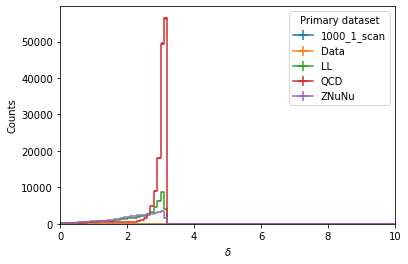

In [102]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

histogram = output['dphiDiFatJet']
ax = hist.plot1d(histogram,overlay="dataset", stack=False)

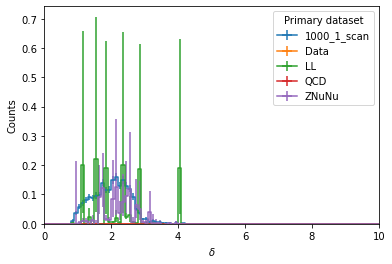

In [103]:
histogram = output['WH_deltaR']
ax = hist.plot1d(histogram,overlay="dataset", stack=False)

In [108]:
from plots.helpers import *
bins = {\
    'N_AK4':    {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{AK4 jet}$', 6, -0.5, 5.5)},
    'N_AK4_SR':    {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{AK4 jet}$', 6, -0.5, 5.5)},
    'N_AK8':    {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{AK8 jet}$', 5, -0.5, 4.5)},
    'N_b':      {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{b-tag}$', 5, -0.5, 4.5)},
    'N_H':      {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{H-tag}$', 5, -0.5, 4.5)},
    'N_W':      {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{W-tag}$', 5, -0.5, 4.5)},

    'MET_pt':   {'axis': 'pt',      'overflow':'over',  'bins': hist.Bin('pt', r'$p_{T}^{miss}\ (GeV)$', 20, 0, 800)},
    'MET_pt_SR':   {'axis': 'pt',      'overflow':'over',  'bins': hist.Bin('pt', r'$p_{T}^{miss}\ (GeV)$', np.array([250,400,600]))},
    'MET_pt_CR':   {'axis': 'pt',      'overflow':'over',  'bins': hist.Bin('pt', r'$p_{T}^{miss}\ (GeV)$', np.array([250,400,600]))},
    'HT':       {'axis': 'ht',      'overflow':'over',  'bins': hist.Bin('pt', r'$H_{T} (AK4 jets) \ (GeV)$', 25, 0, 2000)},    
    'W_pt':     {'axis': 'pt',      'overflow':'over',  'bins': hist.Bin('pt', r'$p_{T} (W-tag)$', 8, 200, 600)},
    'W_eta':    {'axis': 'eta',     'overflow':'over',  'bins': hist.Bin('eta', r'$\eta (W-tag)$', 15, -5.5, 5.5)},
    'H_pt':     {'axis': 'pt',      'overflow':'over',  'bins': hist.Bin('pt', r'$p_{T} (H-tag)$', 8, 200, 600)},
    'H_eta':    {'axis': 'eta',     'overflow':'over',  'bins': hist.Bin('eta', r'$\eta (H-tag)$', 15, -5.5, 5.5)},

    'dphiDiFatJet': {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta \phi (AK8)$', 30, 0, 3)},
    'dphiDiJet':    {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta \phi (AK4)$', 30, 0, 3)},
    'WH_deltaPhi':  {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta \phi (WH)$', 6, 0, 3)},
    'WH_deltaR':    {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta R (WH)$', 10, 0, 5)},
    'bb_deltaPhi':  {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta \phi (bb)$', 30, 0, 3)},
    'bb_deltaR':    {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta R (bb)$', 10, 0, 5)},
    'min_dphiJetMet4': {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta \phi (j, p_{T}^{miss})$', 30, 0, 3)},
        
    'mtb_min':      {'axis': 'mass',  'overflow':'over',  'bins': hist.Bin('pt', r'$min M_{T} (b, p_{T}^{miss}) \ (GeV)$', 25, 0, 500)},
    'lead_AK8_pt':  {'axis': 'pt',    'overflow':'over',  'bins': hist.Bin('pt', r'$p{T} (lead. AK8) \ (GeV)$', 20, 0, 1000)},
    }

In [105]:
from plots.helpers import *

def saveFig( fig, ax, rax, path, name, scale='linear', shape=False, y_max=-1 ):
    outdir = os.path.join(path,scale)
    finalizePlotDir(outdir)
    ax.set_yscale(scale)
    ax.set_ylabel('Events')

    if scale == 'linear':
        if y_max<0 or True:
            pass
        else:
            ax.set_ylim(0, 1 if shape else 1.2*y_max)
    else:
        if y_max<0 and not shape:
            pass
        else:
            ax.set_ylim(0.000005 if shape else 0.05, 3 if shape else 300*y_max)

    handles, labels = ax.get_legend_handles_labels()
    new_labels = []
    for handle, label in zip(handles, labels):
        #print (handle, label)
        try:
            new_labels.append(my_labels[label])
            if not label=='pseudodata':
                handle.set_color(colors[label])
        except:
            pass

    if rax:
        plt.subplots_adjust(hspace=0)
        rax.set_ylabel('Obs./Pred.')
        rax.set_ylim(0.5,1.5)

    ax.legend(title='',ncol=2,handles=handles, labels=new_labels, frameon=False)

    fig.text(0., 0.995, '$\\bf{CMS}$', fontsize=20,  horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )
    fig.text(0.15, 1., '$\\it{Simulation}$', fontsize=14, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )
    fig.text(0.8, 1., '13 TeV', fontsize=14, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )

    fig.savefig(os.path.join(outdir, "{}.pdf".format(name)))
    fig.savefig(os.path.join(outdir, "{}.png".format(name)))
    #ax.clear()

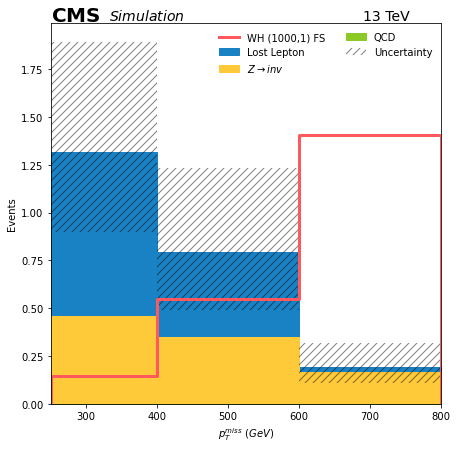

In [106]:
# Make some of the plots

plotDir = '/home/users/dspitzba/public_html/dump/WH_had/'
finalizePlotDir(plotDir)

if True:
    name = 'MET_pt_SR'

    histogram = output[name]

    axis = bins[name]['axis']
    histogram = histogram.rebin(axis, bins[name]['bins'])

    y_max = histogram.sum("dataset").values(overflow='all')[()].max()
    y_over = histogram.sum("dataset").values(overflow='all')[()][-1]

    import re
    bkgonly = re.compile('(?!1000_1_scan)')
    notdata = re.compile('(?!pseudodata)')
    notsignal = re.compile('(?!1000_1_scan)')

    fig, ax = plt.subplots(1,1,figsize=(7,7))
    
    # get axes
    hist.plot1d(histogram[bkgonly], overlay="dataset", ax=ax, stack=True, overflow=bins[name]['overflow'], clear=False, line_opts=None, fill_opts=fill_opts, error_opts=error_opts, order=['QCD', 'ZNuNu', 'LL']) #error_opts??
    hist.plot1d(histogram['1000_1_scan'], overlay="dataset", ax=ax, overflow=bins[name]['overflow'], line_opts={'linewidth':3}, clear=False)

    for l in ['linear']:
        saveFig(fig, ax, None, plotDir, name, scale=l, shape=False, y_max=y_max)


In [107]:
histogram['LL'].values(overflow='over')

{('LL',): array([0.85726557, 0.43957028, 0.02597757])}

In [109]:
# Do some math with LL
name = 'MET_pt_SR'
hist_SR = output['MET_pt_SR'].copy()
hist_CR = output['MET_pt_CR'].copy()
axis = bins[name]['axis']
hist_SR = hist_SR.rebin(axis, bins[name]['bins'])
hist_CR = hist_CR.rebin(axis, bins[name]['bins'])

In [123]:
bkgonly = re.compile('(?!(Data|1000_1_scan))')
CR_data = hist_CR['Data'].sum('dataset').values(overflow='over')[()]
transfer_factor = hist_SR['LL'].sum('dataset').values(overflow='over')[()]/hist_CR[bkgonly].sum('dataset').values(overflow='over')[()]
estimate = CR_data*transfer_factor

In [124]:
estimate

array([0.61699904, 0.36220124, 0.01991697])

In [126]:
# as comparison, pure MC yield
hist_SR['LL'].sum('dataset').values(overflow='over')[()]

array([0.85726557, 0.43957028, 0.02597757])